<a href="https://colab.research.google.com/github/dariaAlium/DA/blob/master/Clustering_Part_2_Dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Алгоритм Dbscan </center>

## Table of contents  
  
1. [Настройка рабочей среды](#set)
2. [Dbscan](#dbscan)
    2. [Пример: Землетрясения](#quake)
    2. [Параметры алгоритма](#dbscan_params)

## Настройка рабочей среды <a name="set"></a>

In [0]:
import numpy as np
import pandas as pd

# будем отображать графики прямо в jupyter'e
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# стиль seaborn
# style.available выводит все доступные стили
#from matplotlib import style
#style.use('seaborn')

#графики в svg выглядят более четкими
#config InlineBackend.figure_format = 'svg' 

## Dbscan <a name="dbscan"></a>

Рассмотрим другой метод кластеризации - `dbscan`.  
При разбиении объектов на группы он также ориентируется на то, какие объекты находятся ближе друг к другу. Но в отличие от иерархической кластеризации, алгоритм dbscan сам определяет количество кластеров (т.е. плотных групп), а также выделяет выбросы - объекты-одиночки, которые не относятся ни к одному кластеру. 
  

Про dbscan есть отличная [статья](https://habrahabr.ru/post/322034/) на хабре - рекомендуется к прочтению.  
Для работы будем использовать реализацию алгоритма из библиотеки scikit-learn, документация [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)  
  
Обзор методов кластеризации, реализованных в scikit-learn: [здесь](http://scikit-learn.org/stable/modules/clustering.html#clustering).

### Пример: Землетрясения <a name="quake"></a>

Рассмотрим работу алгоритма на примере с [землетрясениями](http://sci2s.ugr.es/keel/dataset.php?cod=75):
- `Focal_depth`: глубина эпицентра (км)
- `Latitude`: широта
- `Longitude`: долгота 	
- `Richter`: магнитуда (по шкале Рихтера)

In [0]:
quake_data = pd.read_csv("quake_clear.csv")
quake_data.shape

(2178, 4)

In [0]:
quake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
Focal_depth    2178 non-null int64
Latitude       2178 non-null float64
Longitude      2178 non-null float64
Richter        2178 non-null float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [0]:
quake_data.head(10)

,Focal_depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0
5,0,23.09,120.58,6.2
6,139,-20.70,169.92,6.1
7,60,22.33,93.58,6.0
8,50,-13.64,165.96,6.0
9,119,-16.31,-71.66,6.0


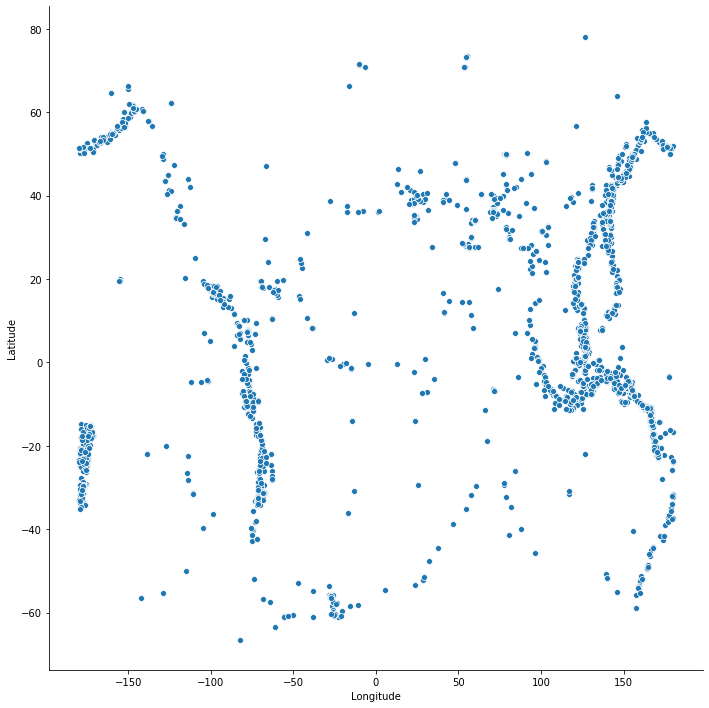

In [0]:
sns.pairplot(x_vars="Longitude", y_vars="Latitude", data=quake_data, height=10)
plt.show()

Перед кластеризацией выполним нормализацию данных - приведем каждый признак к единичной Евклидовой норме. 

In [0]:
from sklearn import preprocessing

In [0]:
# приведение к единичной Евклидовой норме
quake_normalized = pd.DataFrame(preprocessing.normalize(quake_data, norm='l2', axis=0), 
                                columns=quake_data.columns)
np.linalg.norm(quake_normalized, axis=0)

array([1., 1., 1., 1.])

In [0]:
quake_normalized.head(10)

,Focal_depth,Latitude,Longitude,Richter
0,0.005118,-0.035482,0.004632,0.024007
1,0.005583,0.030913,0.024702,0.020782
2,0.008840,0.028414,0.023368,0.020782
3,0.010391,0.019819,0.023101,0.022215
4,0.004653,-0.014706,0.027792,0.021498
5,0.000000,0.015677,0.019735,0.022215
6,0.021558,-0.014054,0.027810,0.021857
7,0.009306,0.015161,0.015316,0.021498
8,0.007755,-0.009261,0.027162,0.021498
9,0.018456,-0.011074,-0.011728,0.021498


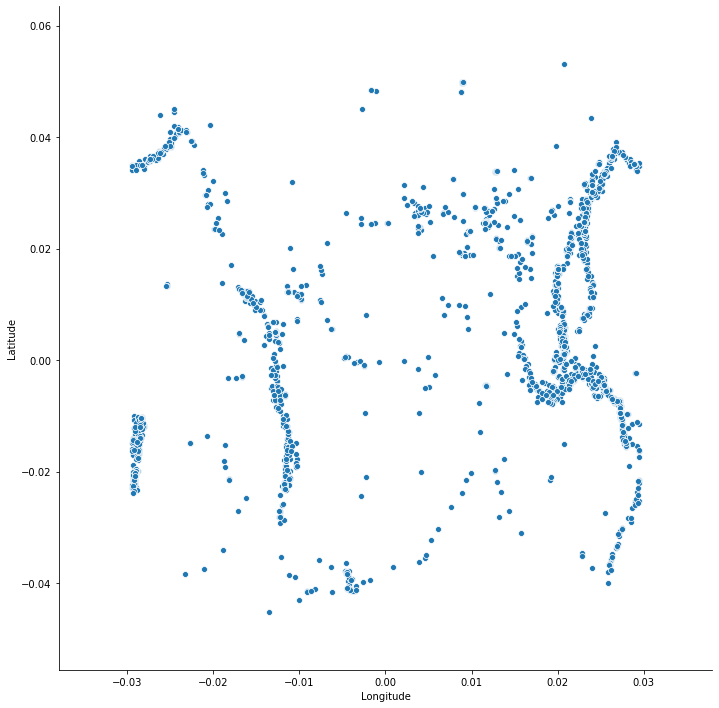

In [0]:
sns.pairplot(x_vars="Longitude", y_vars="Latitude", data=quake_normalized, height=10)
plt.show()

Теперь применим dbscan к нашим данных. Для этого будем использовать функцию `DBSCAN()` из модуля `cluster` библиотеки `scikit-learn`.  
`DBSCAN()` создает объект с заданными параметрами, которые передаются ей при вызове. Чтобы выполнить кластеризацию (обучить алгоритм), необходимо вызвать метод `fit()`, которому передать наши данные. 

In [0]:
from sklearn.cluster import DBSCAN

In [0]:
%%time

cl_dbscan = DBSCAN(eps=0.005, min_samples=10, metric='euclidean')

cl_dbscan.fit(quake_normalized)

Wall time: 37.9 ms


DBSCAN(algorithm='auto', eps=0.005, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

У объекта `cl_dbscan` есть три атрибута: 
* **core\_sample\_indices_** - индексы опорных точек в наборе данных
* **components_** - сами опорные точки (векторы)
* **labels_** - метки кластеров для каждого объекта. Кластера помечаются числами >= 0, `-1` соотвествует выбросам (объектам-одиночкам).

In [0]:
np.shape(cl_dbscan.labels_)

(2178,)

Посмотрим на то, как распределились объекты на корневые, пограничные и выбросы. Видно, что почти все объекты оказались корневыми, т.е. плотность объектов довольно высокая при выбранных параметрах. 

In [0]:
quake_data['points'] = 'Reachable'
quake_data.iloc[cl_dbscan.core_sample_indices_, 4] = 'Core'
quake_data.loc[cl_dbscan.labels_ == -1, 'points'] = 'Outlier'

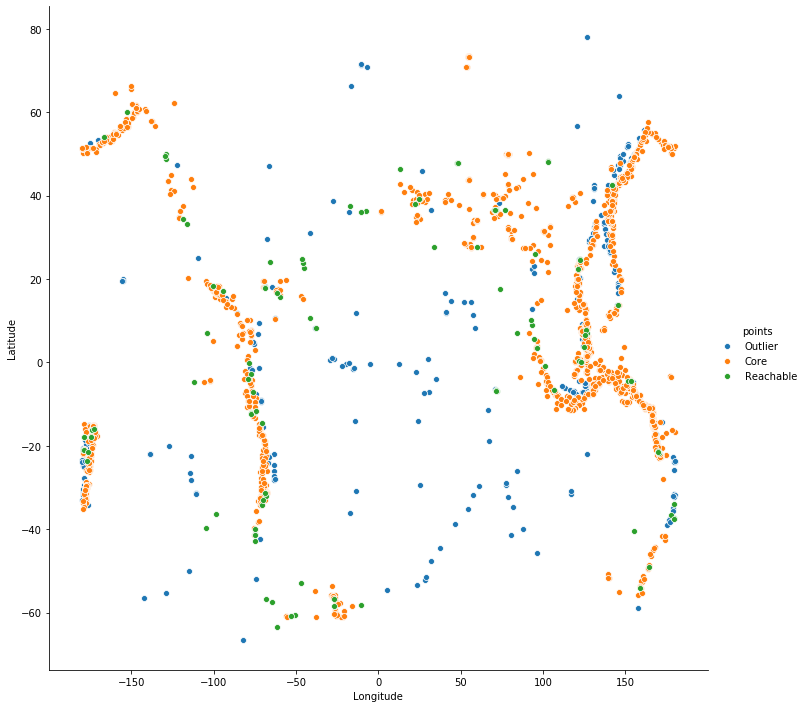

In [0]:
sns.pairplot(x_vars="Longitude", 
             y_vars="Latitude", 
             hue='points',
             data=quake_data, 
             height=10)
plt.show()

Посмотрим теперь на результаты кластеризации. Мы получили 10 кластеров и много выбросов. В целом полученная кластеризация выглядит разумно. Скопление объектов слева разделяется на несколько кластеров из-за сильного разброса по глубине эпицентра.

In [0]:
pd.Series(cl_dbscan.labels_).value_counts()

 0    1263
-1     310
 1     230
 6     121
 3     103
 5      52
 4      32
 7      22
 9      18
 2      15
 8      12
dtype: int64

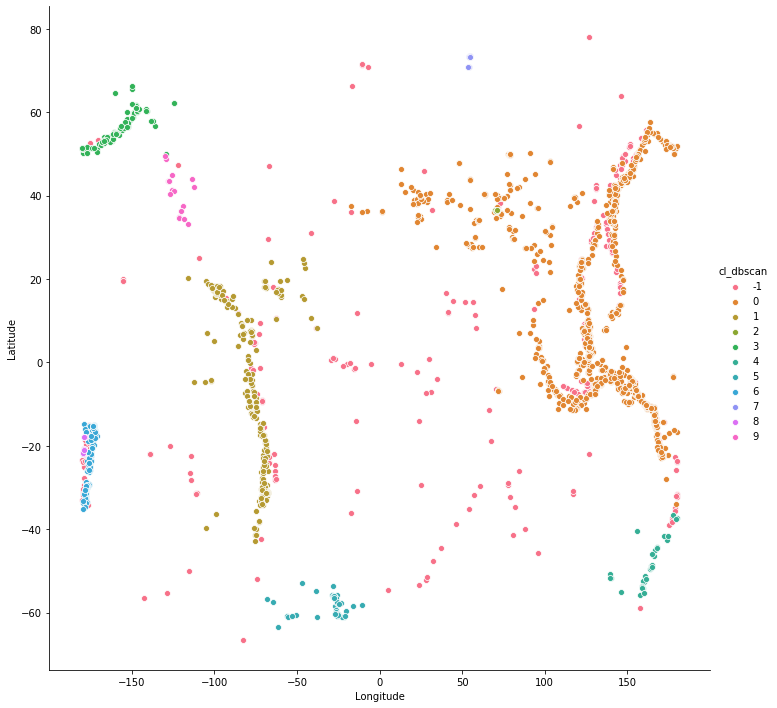

In [0]:
quake_data['cl_dbscan'] = cl_dbscan.labels_

sns.pairplot(x_vars="Longitude", 
             y_vars="Latitude", 
             hue='cl_dbscan',
             data=quake_data, 
             height=10)
plt.show()

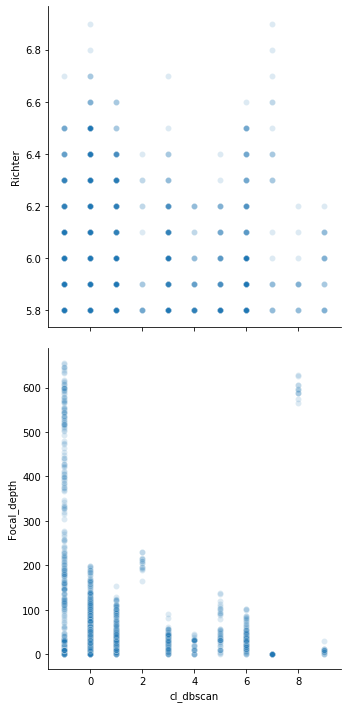

In [0]:
sns.pairplot(x_vars='cl_dbscan', 
             y_vars=['Richter', 'Focal_depth'],
             data=quake_data, 
             height=5,
             plot_kws={'alpha':0.15})
plt.show()

### Параметры алгоритма <a name="dbscan_params"></a>

Как и алгоритмы иерархической кластеризации, dbscan может работать с различными расстояниями между объектами. Они передаются через параметр `metric`, поддерживаются те же, что и в `pdist()`.
Кроме того, в dbscan конечное разбиение сильно зависит от заданных параметров `eps` - границы окрестности, т.е. максимальное растояние до соседа, и `min_sample` - минимальное число соседей, необходимое, чтобы точка стала корневой. Эти параметры необходимо подбирать экспериментально. 

Посмотрим, как изменится результат, если мы изменим параметры `eps` и `min_sample`.

-1     2055
 0       60
 2        9
 1        8
 3        7
 8        7
 9        6
 7        6
 5        5
 10       5
 6        5
 4        5
dtype: int64


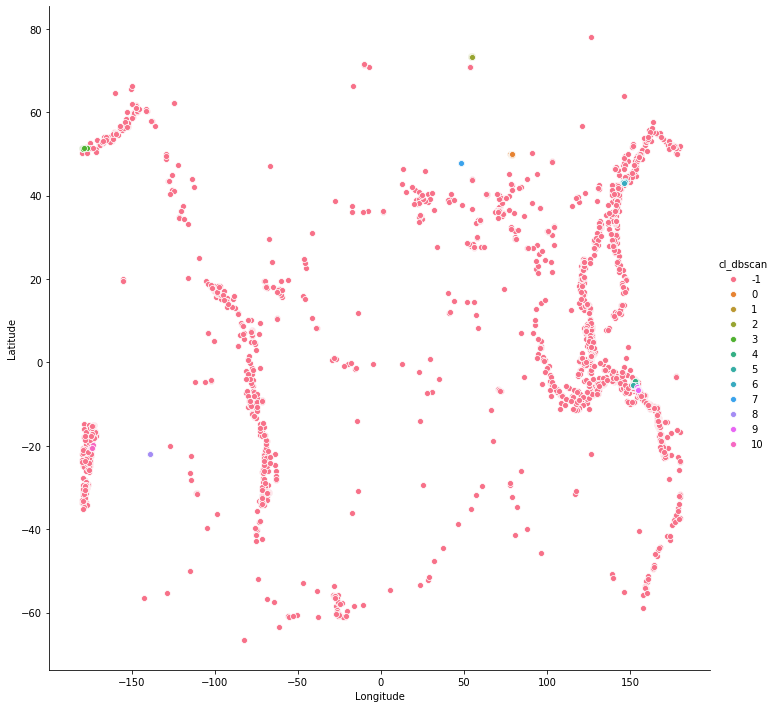

In [0]:
cl_dbscan = DBSCAN(eps=0.0005, min_samples=5, metric='euclidean').fit(quake_normalized)

print(pd.Series(cl_dbscan.labels_).value_counts())

quake_data['cl_dbscan'] = cl_dbscan.labels_

sns.pairplot(x_vars="Longitude", 
             y_vars="Latitude", 
             hue='cl_dbscan',
             data=quake_data, 
             height=10)
plt.show()

 0    1342
 3     395
-1     263
 1     124
 2      54
dtype: int64


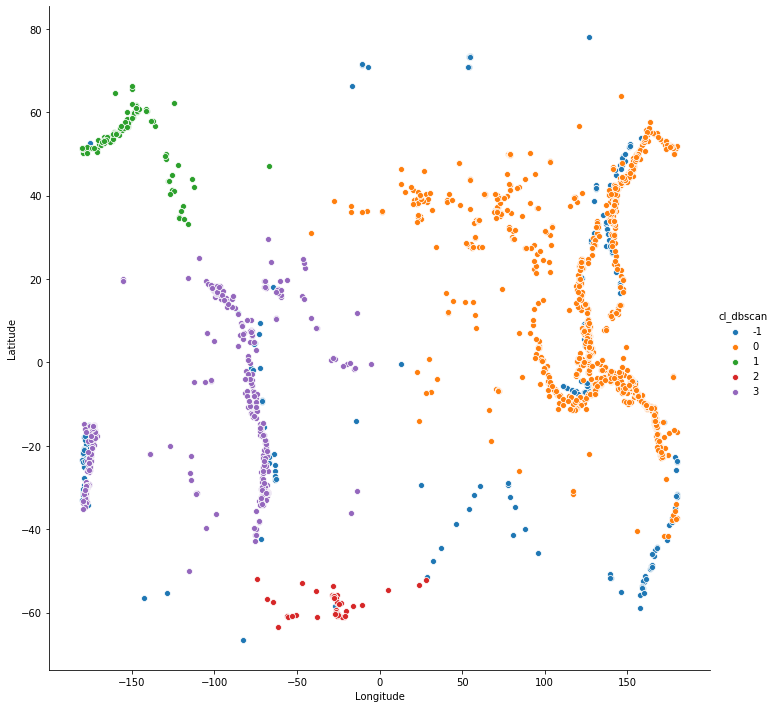

In [0]:
cl_dbscan = DBSCAN(eps=0.01, min_samples=50, metric='euclidean').fit(quake_normalized)

print(pd.Series(cl_dbscan.labels_).value_counts())

quake_data['cl_dbscan'] = cl_dbscan.labels_

sns.pairplot(x_vars="Longitude", 
             y_vars="Latitude", 
             hue='cl_dbscan',
             data=quake_data, 
             height=10)
plt.show()

Существуют эвристики для выбора $m$ *(min_samples)* и $\epsilon$ *(eps)*. Один из наиболее распространенных методов: 

1. Выберите $m$. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять $m$.
2. Вычислите среднее расстояние по $m$ ближайшим соседям для каждой точки. Т.е. если $m=3$, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.
3. Сортируем полученные значения по возрастанию и строим график как в локтевом методе.
4. Видим что-то вроде резко возрастающей кривой. Следует взять $\epsilon$ где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше $\epsilon$, тем больше получатся кластеры, и тем меньше их будет.

# HDbscan

* [Home page](https://hdbscan.readthedocs.io/en/latest/index.html)  
* Installation: [pip](https://pypi.org/project/hdbscan/) or [conda](https://anaconda.org/conda-forge/hdbscan)  
* [Overview](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)

In [0]:
import hdbscan

In [0]:
cl_hdbscan = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
cl_hdbscan.fit(quake_normalized)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
        prediction_data=False)

In [0]:
pd.Series(cl_hdbscan.labels_).value_counts()

 18    897
-1     431
 9     230
 7     129
 10    101
 16     79
 2      55
 6      54
 8      31
 3      27
 1      19
 11     16
 4      16
 17     15
 12     15
 14     15
 15     13
 0      13
 13     12
 5      10
dtype: int64

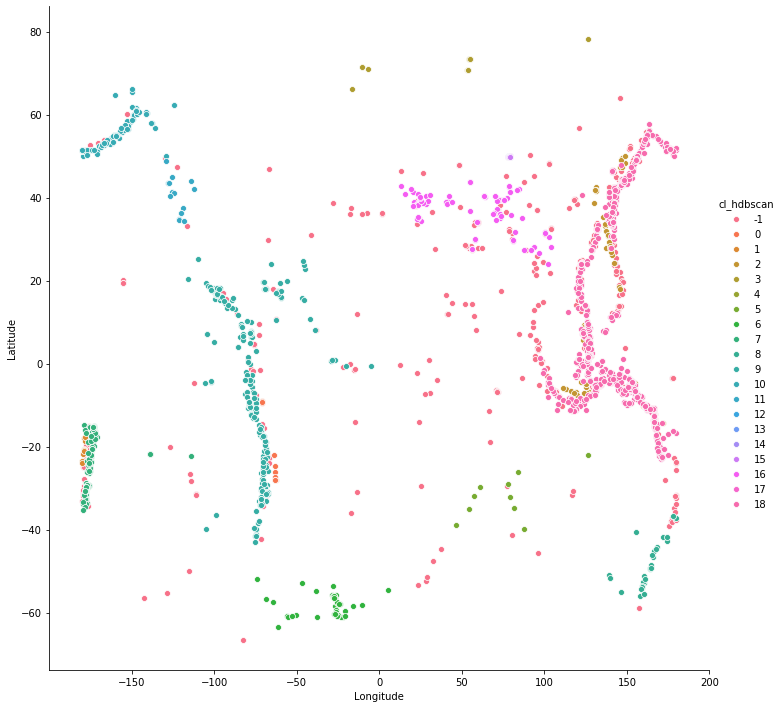

In [0]:
quake_data['cl_hdbscan'] = cl_hdbscan.labels_

sns.pairplot(x_vars="Longitude", 
             y_vars="Latitude", 
             hue='cl_hdbscan',
             data=quake_data, 
             height=10)
plt.show()

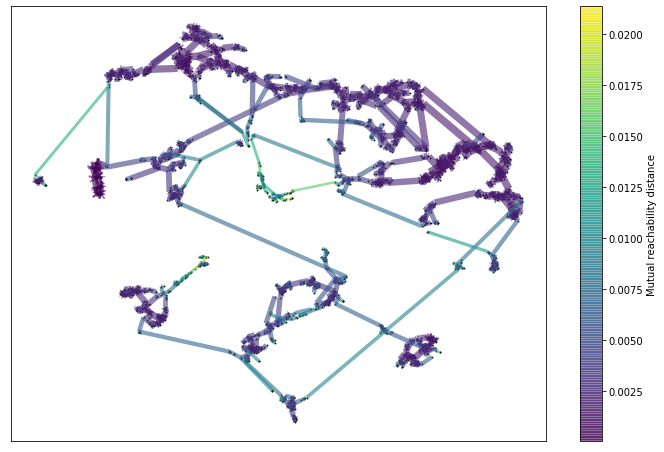

In [0]:
plt.figure(figsize=(12, 8))
cl_hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=1,
                                      edge_linewidth=2)
plt.show()